In [1]:
#from aggregation import *
import scanpy as sc
#import ndd ## for entropy

import glob
import os

import numpy as np
import anndata
#import tables
import scipy.sparse as sp
import pandas as pd
import collections
from typing import Union, Dict, Tuple, List, Callable
from collections import Counter
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import os, sys, string
import h5py
import anndata
import collections
#from harmony import harmonize
import scanpy.external as sce

#import scrublet
#from pandas.compat import map, lmap, u

In [2]:
print(anndata.__version__)
print(sc.__version__)
print(h5py.__version__)

0.10.8
1.10.3
3.11.0


In [5]:
home      = "/data/ep924610/project_nb/paper_code"
datahome  = home+ "data/"
resulthome= home+ "umaps/"

In [6]:
atlas_files = "/data/Kramann_lab/From_Leon/3CA_anndatas/"

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load data
mal_ts = sc.read_h5ad("/data/Kramann_lab/From_Leon/3CA_anndatas/human_skin_ts_after_batcheffect_corrected.h5ad")
skin   = sc.read_h5ad("/data/Kramann_lab/From_Leon/3CA_anndatas/skin/skin_all_after_subclustering_spp1.h5ad")
tdata  = sc.read_h5ad("/data/Kramann_lab/From_Leon/tabula_sapiens/skin_ts_human.h5ad")

# 2. Replace 'nan' with 'Malignant' in mal_ts broad_cell_class
mal_ts.obs['broad_cell_class'] = mal_ts.obs['broad_cell_class'].astype(str).replace('nan', 'Malignant')

In [52]:
# 3. Normalize cell type names (lowercase, stripped)
def norm_names(series):
    return series.astype(str).str.lower().str.strip()

skin.obs['broad_cell_class_norm']   = norm_names(skin.obs['cell_type'])
mal_ts.obs['broad_cell_class_norm'] = norm_names(mal_ts.obs['broad_cell_class'])
tdata.obs['broad_cell_class_norm']  = norm_names(tdata.obs['broad_cell_class'])

# 4. Build color map with red for malignant
all_types = (
    list(skin.obs['broad_cell_class_norm'].unique()) +
    list(mal_ts.obs['broad_cell_class_norm'].unique()) +
    list(tdata.obs['broad_cell_class_norm'].unique())
)
all_types_unique = pd.Series(all_types).unique()

# Assign colors (malignant is red, rest from palette)
base_palette = sns.color_palette("tab20", len(all_types_unique))
color_map = {}
for ct, col in zip(all_types_unique, base_palette):
    if ct == 'malignant':  # Always lowercase due to normalization!
        color_map[ct] = (1.0, 0.0, 0.0) # red (RGB)
    else:
        color_map[ct] = col

# 5. Lighter shades for tdata
from matplotlib.colors import to_rgb
def lighten_color(color, amount=0.4):
    c = np.array(to_rgb(color))
    white = np.array([1, 1, 1])
    return tuple(c + (white - c) * amount)

tdata_color_map = {ct: lighten_color(color_map[ct], amount=0.4) for ct in tdata.obs['broad_cell_class_norm'].unique() if ct in color_map}

# 6. mal_ts color map (malignant is red, others from tdata lighter map)
mal_ts_color_dict = {}
for ct in mal_ts.obs['broad_cell_class_norm'].unique():
    if ct == 'malignant':
        mal_ts_color_dict[ct] = (1.0, 0.0, 0.0)
    elif ct in tdata_color_map:
        mal_ts_color_dict[ct] = tdata_color_map[ct]
    else:
        mal_ts_color_dict[ct] = (0.5, 0.5, 0.5)

# 7. Plotting function with larger figures, no legend, and correct groupby
def plot_umap_with_labels(adata, groupby, color_dict, title, figsize=(10,8), bring_to_front='malignant'):
    import matplotlib.patheffects as PathEffects
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Case-insensitive matching
    bring_to_front = bring_to_front.lower()
    # Get all categories, and move 'malignant' to the end if present
    unique_types = pd.Series(adata.obs[groupby].unique())
    unique_types_lower = unique_types.str.lower()
    if bring_to_front in unique_types_lower.values:
        # Remove 'malignant' from list and append it to the end
        idx = unique_types_lower[unique_types_lower == bring_to_front].index[0]
        categories = list(unique_types.drop(idx)) + [unique_types[idx]]
    else:
        categories = list(unique_types)

    # Make groupby column categorical with desired order
    adata.obs[groupby] = pd.Categorical(adata.obs[groupby], categories=categories, ordered=True)

    # Build palette in same order
    palette = [color_dict.get(ct, (0.5,0.5,0.5)) for ct in categories]

    plt.figure(figsize=figsize)
    sc.pl.umap(
        adata, 
        color=groupby,
        palette=palette,
        show=False,
        legend_loc='none',
        size=20
    )

    ax = plt.gca()
    for ct in categories:
        mask = adata.obs[groupby] == ct
        if np.sum(mask) == 0:
            continue
        x = np.median(adata.obsm['X_umap'][mask, 0])
        y = np.median(adata.obsm['X_umap'][mask, 1])
        txt = ax.text(
            x, y, ct, fontsize=12, weight='bold',
            color=color_dict.get(ct, "black"),
            path_effects=[PathEffects.withStroke(linewidth=3, foreground="white")]
        )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"/data/ep924610/project_nb/paper_code/umaps/{title}.svg")
    plt.show()

<Figure size 1000x800 with 0 Axes>

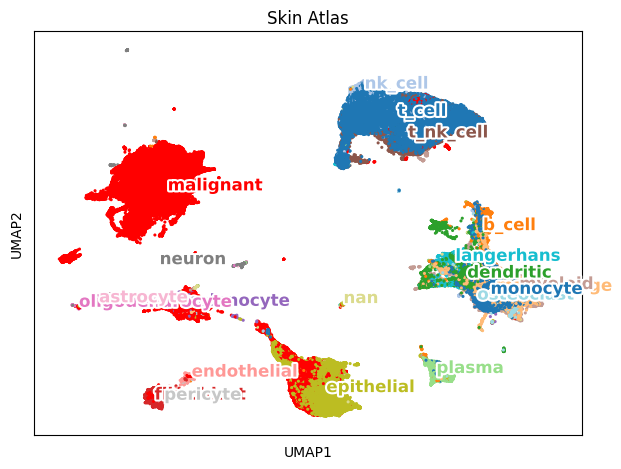

<Figure size 1000x800 with 0 Axes>

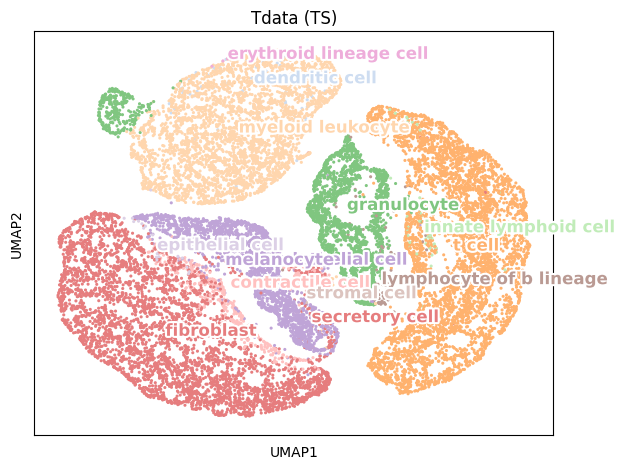

<Figure size 1000x800 with 0 Axes>

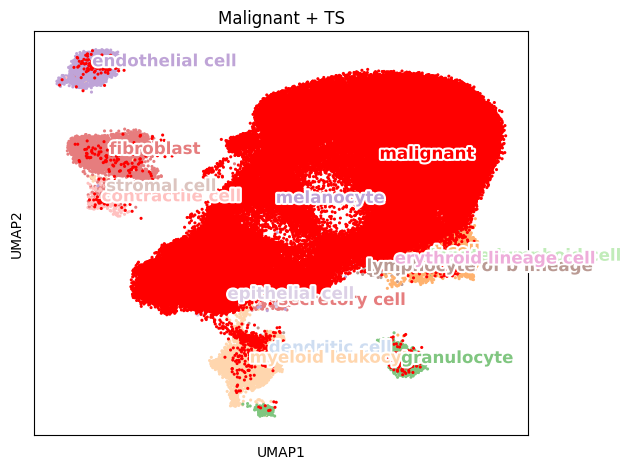

In [53]:
plot_umap_with_labels(skin,   'broad_cell_class_norm', color_map,         'Skin Atlas')
plot_umap_with_labels(tdata,  'broad_cell_class_norm', tdata_color_map,   'Tdata (TS)')
plot_umap_with_labels(mal_ts, 'broad_cell_class_norm', mal_ts_color_dict, 'Malignant + TS')